Getting started using this brown dwarf metric notebook as a guide: https://github.com/yoachim/LSST-BD-Cadence/blob/main/bd_dist_metric.ipynb

In [2]:
from lsst.sims.maf.metrics.baseMetric import BaseMetric
import lsst.sims.maf.utils as mafUtils
import lsst.sims.utils as utils
from scipy import interpolate

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

In [52]:
# Copy and modify the BDParallaxMetric
# As written, this returns the distance to which the parallax S/N condition is met.

# Make it so that it determines the distance to which the _color_ is measured to the S/N threshold.

# Things we would like to consider:
# 1. Make the cut on _color_ S/N rather than on individual filters
# 2. Require seeing better than some threshold for at least X% of i-band images
# 3. Set the limit based on reaching the BHB for more nearby galaxies, and at least ~1.5 mags below the TRGB for the most distant
# 4. Consider crowding criteria? This is crucial (along with good seeing) for stellar pops in the main bodies of nearby gxs.
# 5. Consider S/N based on star/gx separation (i.e., based on the number of stars given a target stellar density (signal),
#    compared to the number of stars+galaxies (noise))

class ColorDistMetric(BaseMetric):
    """Calculate the distance to which one could reach a photometric SNR for a given object

    Uses columns ra_pi_amp and dec_pi_amp, calculated by the ParallaxFactorStacker.

    Parameters
    ----------
    metricName : str, opt
        Default 'parallax'.
    m5Col : str, opt
        The default column name for m5 information in the input data. Default fiveSigmaDepth.
    filterCol : str, opt
        The column name for the filter information. Default filter.
    seeingCol : str, opt
        The column name for the seeing information. Since the astrometry errors are based on the physical
        size of the PSF, this should be the FWHM of the physical psf. Default seeingFwhmGeom.
    mags : dict
        The absolute magnitude of the obeject in question. Keys of filter name, values in mags.
        Start by assuming M_g = 0.6, g-i = -0.4 for a BHB star (update this later, for both BHB and RGB!)
    distances : np.array
        Distances to try putting the object at (kpc). [800 kpc to 6 Mpc]
    atm_err : float, opt
        The expected centroiding error due to the atmosphere, in arcseconds. Default 0.01.
    badval : float, opt
        The value to return when the metric value cannot be calculated. Default 0.
    """
    def __init__(self, metricName='rgbDist', m5Col='fiveSigmaDepth',
                 filterCol='filter', seeingCol='seeingFwhmGeom',
                 mags={'g':0.60, 'i':1.00}, color_snr=5.0,
                 fiducial_band='i', distances=np.arange(800, 6000, 100),
                 normalize=False, **kwargs):
        Cols = [m5Col, filterCol, seeingCol]
        
        units = 'kpc'
        super(ColorDistMetric, self).__init__(Cols, metricName=metricName, units=units,
                                              **kwargs)
        # set return type
        self.m5Col = m5Col
        self.seeingCol = seeingCol
        self.filterCol = filterCol
        self.distances = distances
        if mags.__contains__(fiducial_band):
            self.fiducial_band = fiducial_band
        else:
            # assign the first one in the dict as fiducial if the specified mag isn't there
            self.fiducial_band = list(mags.keys())[0] 
            print('Assigned ',self.fiducial_band,' as the fiducial band, since specified band was not in mags provided.')
        mag1=0
        mag2=0
        for key in mags:
            if key in fiducial_band:
                mag1 = mags[key]
            else:
                mag2 = mags[key]
        self.color = mag2-mag1
        self.mags = {}
        #self.mags = mags
        distance_mod = 5.0*np.log10(distances)-5.0
        for key in mags:
            self.mags[key] = mags[key] + distance_mod
        self.color_snr_goal = color_snr
        self.filters = list(self.mags.keys())
        
    def _mag2_at_color(self, snr1, mag5_1):
        """ Calculate the magnitude of the tracer corresponding to the fiducial m5 mag.
        """
        mag_desired_2 = self.color+mag5_1
        return mag_desired_2

    def run(self, dataslice, slicePoint=None):
        # Assume only two filters
        mag5_1 = np.zeros((np.size(self.mags[self.filters[0]])), dtype='float')
        mag5_2 = np.zeros((np.size(self.mags[self.filters[0]])), dtype='float')
        snr1 = np.zeros((np.size(self.mags[self.filters[0]])), dtype='float')
        snr2 = np.zeros((np.size(self.mags[self.filters[0]])), dtype='float')
        snr2_m5 = np.zeros((np.size(self.mags[self.filters[0]])), dtype='float')
        # snr = np.zeros((np.size(self.mags[self.filters[0]]), 2), dtype='float')
        # compute SNR for all observations
        for filt in self.filters:
            print('filter: ',filt)
            good = np.where(dataslice[self.filterCol] == filt)[0]
            print('size good: ', np.size(good), np.size(good[0]))
            if np.size(good) > 0:
                #snr[:, colnum] = mafUtils.m52snr(self.mags[str(filt)][:, np.newaxis],
                #                                 dataslice[self.m5Col][good])
            # Place the "fiducial" band first:
                if filt == self.fiducial_band:
                    snr1 = mafUtils.m52snr(self.mags[str(filt)],
                                           dataslice[self.m5Col][good])
                    mag5_1 = self.mags[str(filt)]
                else:
                    snr2_m5 = mafUtils.m52snr(self.mags[str(filt)],
                                              dataslice[self.m5Col][good])
                    m5Col2 = dataslice[self.m5Col][good]
                    mag5_2 = self.mags[str(filt)]

        mag5_target_2 = self._mag2_at_color(snr1, mag5_1)
        snr2 = mafUtils.m52snr(mag5_2, m5Col2)
        snr_color = np.sqrt(snr1**2 + snr2**2)
                 
        result = 0.0
        print(np.shape(snr_color))
        # Let's interpolate to the distance where we would get our target SNR
        if np.max(snr_color) >= self.color_snr_goal:
            f = interpolate.interp1d(snr_color, self.distances, fill_value="extrapolate")
            result = f(self.color_snr_goal)
        return result

In [ ]:
# Copy and modify the BDParallaxMetric
# As written, this returns the distance to which the parallax S/N condition is met.

# Make it so that it determines the distance to which the _color_ is measured to the S/N threshold.

# Things we would like to consider:
# 1. Make the cut on _color_ S/N rather than on individual filters
# 2. Require seeing better than some threshold for at least X% of i-band images
# 3. Set the limit based on reaching the BHB for more nearby galaxies, and at least ~1.5 mags below the TRGB for the most distant
# 4. Consider crowding criteria? This is crucial (along with good seeing) for stellar pops in the main bodies of nearby gxs.
# 5. Consider S/N based on star/gx separation (i.e., based on the number of stars given a target stellar density (signal),
#    compared to the number of stars+galaxies (noise))

class starDistMetric(BaseMetric):
    """Calculate the distance to which one could reach a photometric SNR for a given object

    Uses columns ra_pi_amp and dec_pi_amp, calculated by the ParallaxFactorStacker.

    Parameters
    ----------
    metricName : str, opt
        Default 'parallax'.
    m5Col : str, opt
        The default column name for m5 information in the input data. Default fiveSigmaDepth.
    filterCol : str, opt
        The column name for the filter information. Default filter.
    seeingCol : str, opt
        The column name for the seeing information. Since the astrometry errors are based on the physical
        size of the PSF, this should be the FWHM of the physical psf. Default seeingFwhmGeom.
    mags : dict
        The absolute magnitude of the obeject in question. Keys of filter name, values in mags.
        Start by assuming M_g = 0.6, g-i = -0.4 for a BHB star (update this later, for both BHB and RGB!)
    distances : np.array
        Distances to try putting the object at (kpc). [800 kpc to 6 Mpc]
    atm_err : float, opt
        The expected centroiding error due to the atmosphere, in arcseconds. Default 0.01.
    badval : float, opt
        The value to return when the metric value cannot be calculated. Default 0.
    """
    def __init__(self, metricName='starDist', m5Col='fiveSigmaDepth',
                 filterCol='filter', seeingCol='seeingFwhmGeom',
                 absmags={'g':0.6, 'i':1.00}, percentile=90, normalize=False, **kwargs):
        Cols = [m5Col, filterCol]
        units = 'kpc'
        super(stellarDistMetric, self).__init__(Cols, metricName=metricName, units=units,
                                            **kwargs)
        # set return type
        self.m5Col = m5Col
        self.percentile = percentile
        self.filterCol = filterCol
        self.filters = list(absmags.keys())
        self.absmags = absmags

    def run(self, dataslice, slicePoint=None):
        dmods = np.zeros((np.size(self.absmags[self.filters[0]]), len(dataslice)), dtype='float')
        # compute distance modulus reached for all observations
        for filt in self.filters:
            good = np.where(dataslice[self.filterCol] == filt)[0]
            if np.size(good) > 0:
                dmods[:, good] = dataslice[self.m5Col][good]-self.absmags[filt]

        distances_kpc = (10.0**((dmods+5.0)/5))/1000.0
        return np.percentile(distances_kpc, self.percentile)


In [9]:
# Copy and modify the BDParallaxMetric
# As written, this returns the distance to which the parallax S/N condition is met.

# Make it so that it determines the distance to which the _color_ is measured to the S/N threshold.

# Things we would like to consider:
# 1. Make the cut on _color_ S/N rather than on individual filters
# 2. Require seeing better than some threshold for at least X% of i-band images
# 3. Set the limit based on reaching the BHB for more nearby galaxies, and at least ~1.5 mags below the TRGB for the most distant
# 4. Consider crowding criteria? This is crucial (along with good seeing) for stellar pops in the main bodies of nearby gxs.
# 5. Consider S/N based on star/gx separation (i.e., based on the number of stars given a target stellar density (signal),
#    compared to the number of stars+galaxies (noise))

class stellarDistMetric(BaseMetric):
    """Calculate the distance to which one could reach a photometric SNR for a given object

    Uses columns ra_pi_amp and dec_pi_amp, calculated by the ParallaxFactorStacker.

    Parameters
    ----------
    metricName : str, opt
        Default 'parallax'.
    m5Col : str, opt
        The default column name for m5 information in the input data. Default fiveSigmaDepth.
    filterCol : str, opt
        The column name for the filter information. Default filter.
    seeingCol : str, opt
        The column name for the seeing information. Since the astrometry errors are based on the physical
        size of the PSF, this should be the FWHM of the physical psf. Default seeingFwhmGeom.
    mags : dict
        The absolute magnitude of the obeject in question. Keys of filter name, values in mags.
        Start by assuming M_g = 0.6, g-i = -0.4 for a BHB star (update this later, for both BHB and RGB!)
    distances : np.array
        Distances to try putting the object at (kpc). [800 kpc to 6 Mpc]
    atm_err : float, opt
        The expected centroiding error due to the atmosphere, in arcseconds. Default 0.01.
    badval : float, opt
        The value to return when the metric value cannot be calculated. Default 0.
    """
    def __init__(self, metricName='stellarDist', m5Col='fiveSigmaDepth',
                 filterCol='filter', seeingCol='seeingFwhmGeom',
                 absmags={'g':0.6, 'i':1.00}, percentile=90, normalize=False, **kwargs):
        Cols = [m5Col, filterCol]
        units = 'kpc'
        super(stellarDistMetric, self).__init__(Cols, metricName=metricName, units=units,
                                            **kwargs)
        # set return type
        self.m5Col = m5Col
        self.percentile = percentile
        self.filterCol = filterCol
        self.filters = list(absmags.keys())
        self.absmags = absmags

    def run(self, dataslice, slicePoint=None):
        dmods = np.zeros((np.size(self.absmags[self.filters[0]]), len(dataslice)), dtype='float')
        # compute SNR for all observations
        for filt in self.filters:
            good = np.where(dataslice[self.filterCol] == filt)[0]
            if np.size(good) > 0:
                dmods[:, good] = dataslice[self.m5Col][good]-self.absmags[filt]
#                dmods[:, good] = dataslice[self.m5Col][good][:,np.newaxis]-self.absmags[filt]

        distances_kpc = (10.0**((dmods+5.0)/5))/1000.0
        return np.percentile(distances_kpc, self.percentile)

/data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metrics/baseMetric.py:39: UserWarning: Redefining metric __main__.stellarDistMetric! (there are >1 metrics with the same name)
  warnings.warn('Redefining metric %s! (there are >1 metrics with the same name)' % (metricname))


In [5]:
class VolumeSumMetric(BaseMetric):
    """Compute the total volume assuming a metric has values of distance
    """
    def __init__(self, col=None, metricName='VolumeSum', nside=None, **kwargs):
        super(VolumeSumMetric, self).__init__(col=col, metricName=metricName, **kwargs)
        self.pix_area = hp.nside2pixarea(nside)
        
    def run(self, dataSlice, slicePoint=None):
        # volume of sphere, times ratio of pixel area divided by area of sphere
        vols = 1./3. * dataSlice[self.colname]**3 * self.pix_area
        return np.sum(vols)

In [6]:
dbFile = '/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs.db'
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [55]:
nside=16
bundleList = []
#sql = 'filter="z" or filter="y"'
#sqlconstraint = 'filter = "r" and night < 365'
sql = 'night < 2000'
#sql = 'night < 2000 and (filter="g" or filter="i")'
# Let's plug in the magnitudes for one type
#metric = ColorDistMetric(mags={'g': 0.0, 'i': -1.0}, fiducial_band='i', metricName='RGBColorDist')
#slicer = slicers.HealpixSlicer(nside=nside)
##summaryStats = [VolumeSumMetric(nside=nside)]
#plotDict = {}
#bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
#                                             runName=runName))
##                                             summaryMetrics=summaryStats,

# Now the mags for another type
metric = stellarDistMetric(absmags={'g':0.6, 'i':1.00}, metricName='BHBDist')
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             runName=runName))
#bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
#                                             summaryMetrics=summaryStats,
#                                             runName=runName))


Querying database SummaryAllProps with constraint night < 2000 for columns ['fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth']
Found 1131931 visits
Running:  ['_sims_maf_fbs_1_7_baseline_baseline_nexp2_v1_7_10yrs_BHBDist_night_lt_2000_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night < 2000" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 422.271  dipole: lon: 108.861, lat: -22.0305, amp: 18.5874
  mono, lon, lat, amp


Plotting complete.


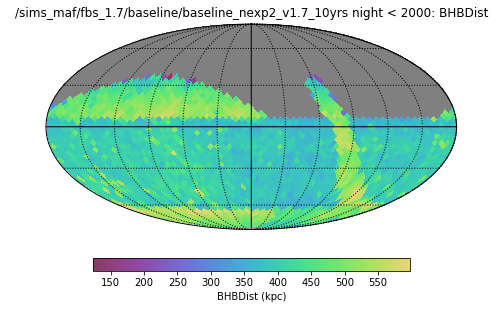

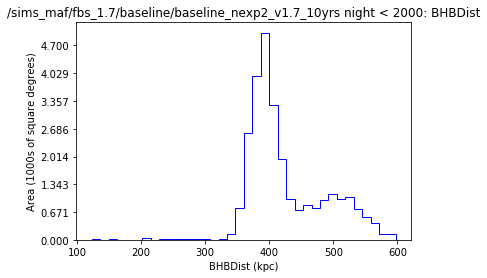

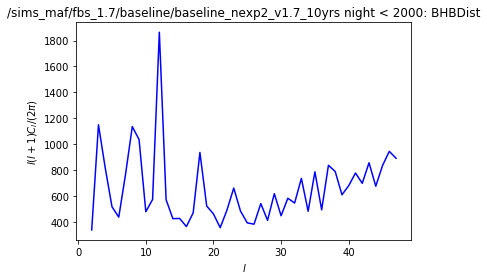

In [56]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [95]:
mmm = {'g':33, 'i':44}

In [88]:
aa = mmm.get('z')
print(aa)

None


In [131]:
aa = list(mmm.keys())

In [134]:
list(mmm.keys())[0]

'g'